# Prepare Participants Lists

**Author**: Haroon Popal

This notebook will create the **participants.tsv** file in the BIDS format which will include the subject ID and demographic information for all participants with fmriprep data. The notebook will also create a second list of participants and their run data, **participants_good_SR.csv**, for the social reward task that meets quality control thresholds. Participants may be exluced for excessive motion and/or poor MRI run quality, or if there were issues with their task run data. 

In [1]:
import os
import sys
import glob
import pandas as pd
import numpy as np
from datetime import datetime, date

import seaborn as sns
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/sit

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/lib/python3.11/runpy.py", line 198, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/lib/python3.11/runpy.py", line 88, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/lib/python3.11/sit

AttributeError: _ARRAY_API not found

In [3]:
proj_dir = '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'

os.chdir(proj_dir)

# BIDS Participants List

## Import QC spreadsheet
This spreadsheet is derived from the [SCN fMRI Master Log](https://docs.google.com/spreadsheets/d/1-MOW372sO0g1y9cKl1_GkhMunp0lgdst11etN7qmZvU/edit#gid=158950615) QC tab and contains information on all participants who were scanned, and the quality control reading each of their runs.

In [5]:
mriqc_raw = pd.read_csv(proj_dir+'misc/SCN fMRI Master Log - QC.csv', index_col=0)
mriqc_raw.head()

,Unnamed: 1,Anatomical,192x512x512,Unnamed: 4,Unnamed: 5,Unnamed: 6,HBN movie - Run 1,Unnamed: 8,NS - Run 1,Unnamed: 10,...,SR - Run 3,Unnamed: 20,SR - Run 4,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
,,,,,,,,,,,,,,,,,,,,,
SID,Reviewer,T1w,Dimension #s,Norm1,Norm2,Norm3,Alignment,Time: # of Volumes,Alignment,Time: # of Volumes,...,Alignment,Time: # of Volumes,Alignment,Time: # of Volumes,Error Messages,Checked Reprocessed Data?,NaN,Overall Notes,"frontal drop-off rating (1=least, 5=most)",wrap-around artifact
SCN_101,NaN,good,192x512x512,good,good,good,good,170,good,518.75,...,good,300,good,300,Node Name: fmriprep_wf.single_subject_SCN101_w...,TRUE,NaN,"smudging in NS 2 and SR 2, general pixellation...",5,yes
SCN_102,NaN,good,192x512x512,good,good,good,good,170,good,518.75,...,good,300,good,300,No errors to report!,TRUE,NaN,pixellation in all moving runs,1,no
SCN_103,NaN,good,192x512x512,good,good,good,good,170,good,518.75,...,good,300,good,300,No errors to report!,TRUE,NaN,NaN,4,yes
SCN_104,NaN,good,192x512x512,good,good,good,good,170,good,518.75,...,good,300,good,300,No errors to report!,TRUE,NaN,"most have some smudges, but small enough (NS 1...",2,yes


In [7]:
# Pull just the participant IDs
participant_list = [x for x in mriqc_raw.index if str(x).startswith('SCN')]

## Import Demographic Info

In [10]:
# Import Redcap demographics info
redcap_info = pd.read_csv(glob.glob(os.path.join(proj_dir, 'misc',
                                                 'SCONNChildPacket-Id*.csv'))[0])

# Identify relevent columns in the Redcap dataframe
relv_cols = ['record_id', 'child_gender_lab_entered', 'child_birthday',
             'date_of_visit', 'group']

redcap_info_fltr = redcap_info[relv_cols]

# Capitalize subject name to standardize
redcap_info_fltr.loc[:,'record_id'] = redcap_info_fltr['record_id'].str.upper()

# Remove records that don't start with project code
redcap_info_fltr = redcap_info_fltr[redcap_info_fltr['record_id'].str.startswith('SCN')]

redcap_info_fltr.head()

,record_id,child_gender_lab_entered,child_birthday,date_of_visit,group
24,SCN_101,2.0,12/10/2008,3/25/2022,1.0
25,SCN_102,1.0,11/11/2009,3/28/2022,1.0
26,SCN_103,2.0,9/16/2010,4/3/2022,1.0
27,SCN_104,1.0,10/23/2009,3/26/2022,1.0
28,SCN_105,4.0,1/4/2008,5/27/2022,2.0


In [12]:
# Filter to only capture subjects with fmriprep data

# Create a copy of the redcap data
fmriprep_demo = redcap_info_fltr.copy()

# Rename subject IDs to match fmripre IDs
#fmriprep_demo['record_id'] = 'sub-' + fmriprep_demo['record_id']
#fmriprep_demo['record_id'] = fmriprep_demo['record_id'].str.replace('_', '', 
#                                                                    regex=True)

# Filter
fmriprep_demo = fmriprep_demo[fmriprep_demo['record_id'].isin(participant_list)]

# Fill nan with empty strings
fmriprep_demo = fmriprep_demo.fillna('')

fmriprep_demo.head()

,record_id,child_gender_lab_entered,child_birthday,date_of_visit,group
24,SCN_101,2.0,12/10/2008,3/25/2022,1.0
25,SCN_102,1.0,11/11/2009,3/28/2022,1.0
26,SCN_103,2.0,9/16/2010,4/3/2022,1.0
27,SCN_104,1.0,10/23/2009,3/26/2022,1.0
28,SCN_105,4.0,1/4/2008,5/27/2022,2.0


### Calculate age

In [15]:
fmriprep_demo['age'] = ''

for n in fmriprep_demo.index:
    # Select the birth date
    date_birth_str = fmriprep_demo.loc[n, 'child_birthday']
    
    if len(date_birth_str.split('/')[-1]) == 2:
        date_birth = datetime.strptime(date_birth_str, 
                                   "%m/%d/%y").date()
    elif len(date_birth_str.split('/')[-1]) == 4:
        date_birth = datetime.strptime(date_birth_str, 
                                   "%m/%d/%Y").date()
    else:
        continue
        
        
    # Select the birth date
    date_study_str = fmriprep_demo.loc[n, 'date_of_visit']    
    date_study_str = date_study_str.split(' + ')[0]
    
    if len(date_study_str.split('/')[-1]) == 2:
        date_study = datetime.strptime(date_study_str, 
                                   "%m/%d/%y").date()
    elif len(date_study_str.split('/')[-1]) == 4:
        date_study = datetime.strptime(date_study_str, 
                                   "%m/%d/%Y").date()
    else:
        continue
    
    
    
    # Subtract to find the age in days and divide by number of days in year
    # accounting for leap years
    age = (date_study - date_birth).days / 365.25
    
    # Round and input into demo dataframe
    fmriprep_demo.loc[n, 'age'] = round(age, 2)

In [17]:
# Rename columns
fmriprep_demo = fmriprep_demo.rename(columns={'record_id': 'participant_id', 
                                              'child_gender_lab_entered': 'gender'})

# Filter for only relevent columns
outp_cols = ['participant_id', 'age', 'gender', 'group']

fmriprep_demo = fmriprep_demo[outp_cols]

### Visualize Demographics

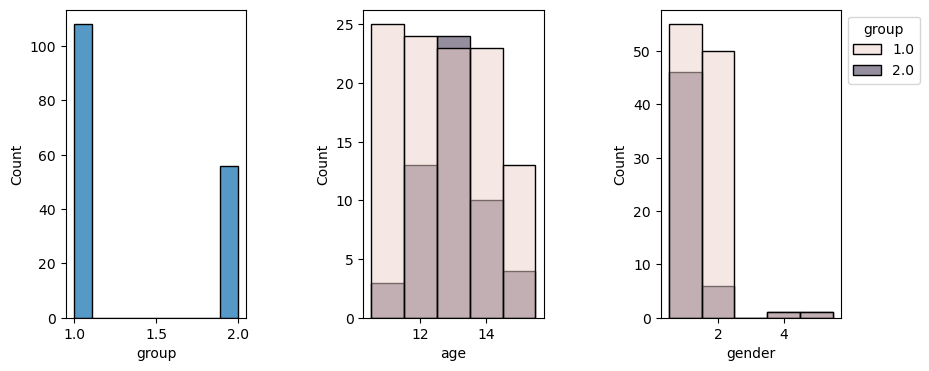

In [20]:
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
ax = sns.histplot(fmriprep_demo, x='group')

plt.subplot(1, 3, 2)
sns.histplot(fmriprep_demo, x='age', hue='group', legend=False)

plt.subplot(1, 3, 3)
ax = sns.histplot(fmriprep_demo, x='gender', hue='group')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace = 0.65)

### Fix participant IDs

In [23]:
fmriprep_demo['participant_id'] = 'sub-' + fmriprep_demo['participant_id']
fmriprep_demo['participant_id'] = fmriprep_demo['participant_id'].str.replace('_', '', 
                                                                    regex=True)

## Export General List

In [26]:
fmriprep_demo.to_csv(proj_dir+'/participants.tsv', sep='\t', 
                                index=False)

***

# Imaging QC

This section will create a list of participants which have passed the lab based MRI QC protocols. 

## Import QC Data

In [31]:
# Drop irrelevant rows
mriqc = mriqc_raw.drop([x for x in mriqc_raw.index if not str(x).startswith('SCN')])

# Remove irrelvant columns
irr_col_names = [x for x in mriqc.columns if not x.startswith('SR - ')]
mriqc = mriqc.drop(columns=irr_col_names)

# Add fmriprep sub- prefix
mriqc.index = 'sub-'+ mriqc.index

# Remove underscore for participant ID
mriqc.index = [sub.replace('_', '') for sub in mriqc.index]

# Name index column
mriqc.index.name = 'participant_id'

mriqc.head()

,SR - Run 1,SR - Run 2,SR - Run 3,SR - Run 4
participant_id,,,,
sub-SCN101,good,good,good,good
sub-SCN102,good,good,good,good
sub-SCN103,good,good,good,good
sub-SCN104,good,good,good,good
sub-SCN105,good,good,good,good


In [33]:
# Clean up extra spaces at the end of column values
for col in mriqc.columns:
    mriqc[col] = mriqc[col].str.strip()

Total number of participants:

In [36]:
len(mriqc)

167

Turn to long format

In [39]:
mriqc_melt = pd.melt(mriqc.reset_index(), id_vars='participant_id', var_name='run')
mriqc_melt.head()

,participant_id,run,value
0,sub-SCN101,SR - Run 1,good
1,sub-SCN102,SR - Run 1,good
2,sub-SCN103,SR - Run 1,good
3,sub-SCN104,SR - Run 1,good
4,sub-SCN105,SR - Run 1,good


## Visualize MRI QC Metadata

### All MRI QC values

<Axes: xlabel='run,value'>

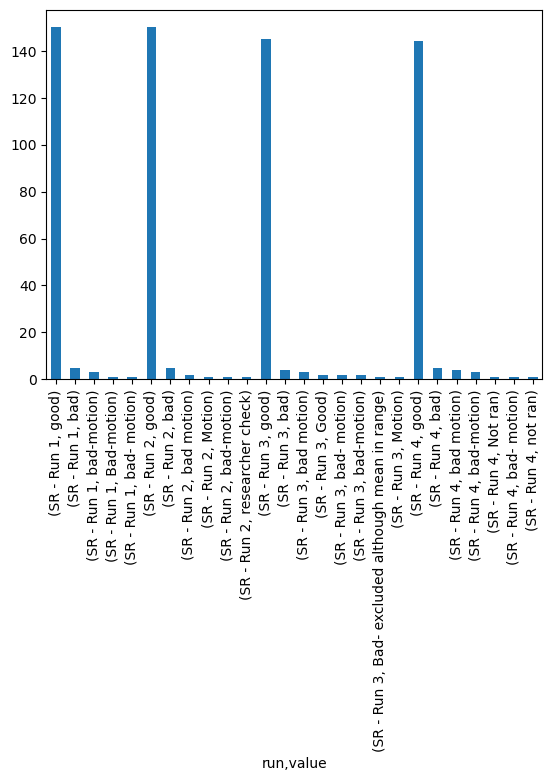

In [43]:
mriqc_melt.groupby('run')['value'].value_counts().plot.bar()

Count the number of participants that are being completly excluded because none of their scan data is usable:

In [46]:
len(mriqc_melt[mriqc_melt['value'] != 'good']['participant_id'].unique())

35

### Number of good scans

In [49]:
mriqc_melt_good = mriqc_melt[mriqc_melt['value'] == 'good']

<Axes: xlabel='run,value'>

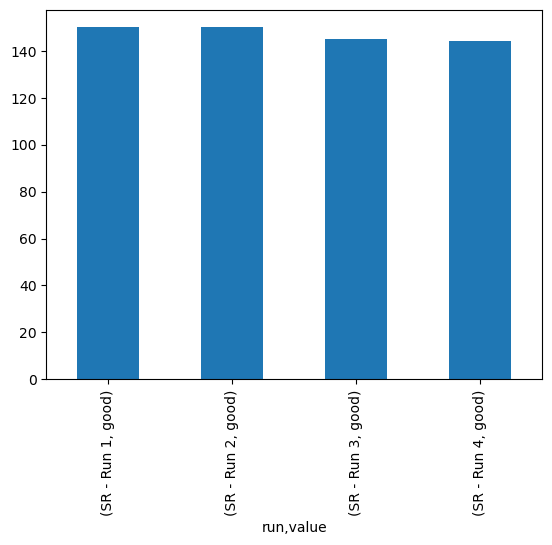

In [51]:
mriqc_melt_good.groupby('run')['value'].value_counts().plot.bar()

### Visualize demographics

In [54]:
fmriprep_demo_qc = fmriprep_demo[fmriprep_demo['participant_id'].isin(mriqc_melt_good['participant_id'].unique())]


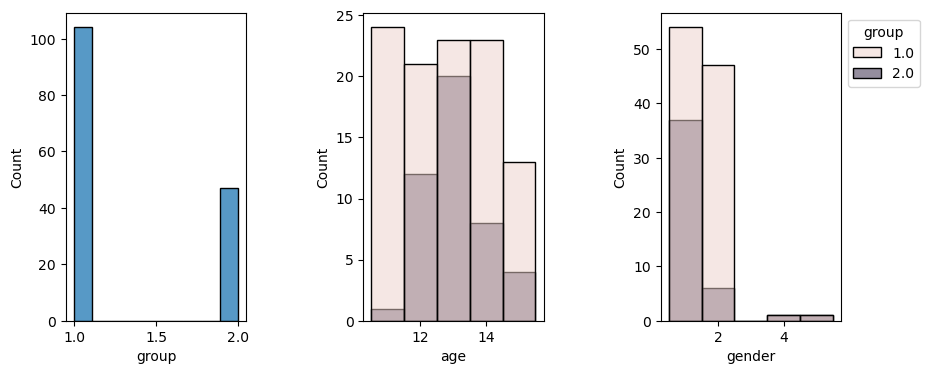

In [56]:
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
ax = sns.histplot(fmriprep_demo_qc, x='group')

plt.subplot(1, 3, 2)
sns.histplot(fmriprep_demo_qc, x='age', hue='group', legend=False)

plt.subplot(1, 3, 3)
ax = sns.histplot(fmriprep_demo_qc, x='gender', hue='group')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace = 0.65)

## Export "Good" MRI QC Participant and Run Info

In [59]:
mriqc_melt_good[['participant_id','run']].to_csv(proj_dir+'derivatives/participants-qc.csv', 
                                                 index=False)

***

# Behavioral QC
The task programming had an error which would show the participant incorrect options for their own preferences (e.g. would show "like animals", when the participant said they didn't like animals). We will remove participants for which this occurred a lot (more than 5 trial).

## Import Task Audit Data
This data comes from another script which examine the output of each task run for each participant, and calculates the number of errors per participant. An error is defined as when an item was shown as the incorrect valence that the participant indicated in their survey. For example, display "I like animals", when the participant had said that they do not like animals. 

In [23]:
task_audit = pd.read_csv(os.path.join(proj_dir, 'derivatives', 'task_socialreward', 'data', 
                                      'answer_errors_sum.csv'), index_col=0)
task_audit.head()

,num_errors
SCN_101,0
SCN_102,0
SCN_103,0
SCN_104,0
SCN_105,0


Count the number of participants that will be excluded because of errors in their task

In [24]:
len(task_audit[task_audit['num_errors'] > 0])

40

## Minimum Errors

Create a participant list with participants who had minimum errors. 

In [25]:
# Filter subjects for no errors
task_audit_subjs_min_err = task_audit.index[task_audit['num_errors'] < 6]

# Change subject labels to match MRI data
task_audit_subjs_min_err = ['sub-'+x.replace('_','') for x in task_audit_subjs_min_err]


Filter the MRI QC passed subjects with the behavioral QC passed subjects

### Visualize Errors

In [26]:
mriqc_melt_good_min_err = mriqc_melt_good[mriqc_melt_good['participant_id'].isin(task_audit_subjs_min_err)]


<Axes: xlabel='run,value'>

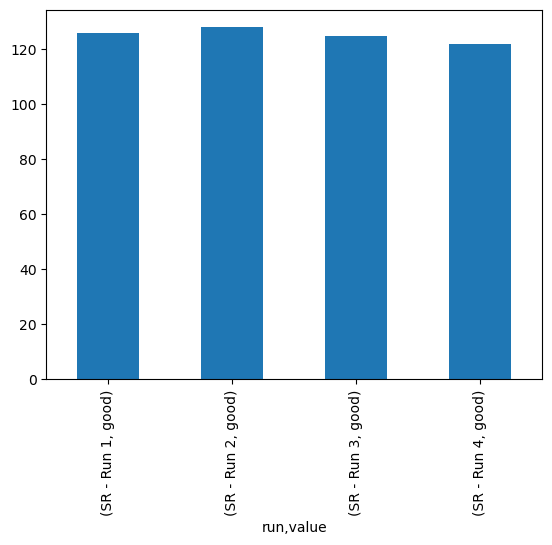

In [27]:
mriqc_melt_good_min_err.groupby('run')['value'].value_counts().plot.bar()


### Visualize Demographics

In [28]:
fmriprep_demo_qc_min = fmriprep_demo[fmriprep_demo['participant_id'].isin(mriqc_melt_good_min_err['participant_id'].unique())]


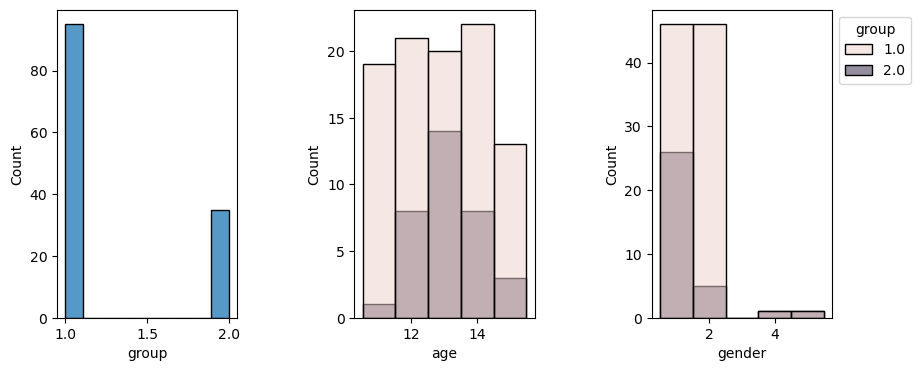

In [29]:
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
ax = sns.histplot(fmriprep_demo_qc_min, x='group')

plt.subplot(1, 3, 2)
sns.histplot(fmriprep_demo_qc_min, x='age', hue='group', legend=False)

plt.subplot(1, 3, 3)
ax = sns.histplot(fmriprep_demo_qc_min, x='gender', hue='group')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace = 0.65)

In [30]:
fmriprep_demo_qc_min['participant_id'].to_list()

['sub-SCN101',
 'sub-SCN102',
 'sub-SCN103',
 'sub-SCN104',
 'sub-SCN105',
 'sub-SCN106',
 'sub-SCN107',
 'sub-SCN108',
 'sub-SCN109',
 'sub-SCN110',
 'sub-SCN112',
 'sub-SCN117',
 'sub-SCN118',
 'sub-SCN119',
 'sub-SCN120',
 'sub-SCN121',
 'sub-SCN122',
 'sub-SCN123',
 'sub-SCN124',
 'sub-SCN125',
 'sub-SCN126',
 'sub-SCN127',
 'sub-SCN128',
 'sub-SCN129',
 'sub-SCN133',
 'sub-SCN134',
 'sub-SCN135',
 'sub-SCN141',
 'sub-SCN142',
 'sub-SCN143',
 'sub-SCN144',
 'sub-SCN145',
 'sub-SCN147',
 'sub-SCN149',
 'sub-SCN151',
 'sub-SCN152',
 'sub-SCN154',
 'sub-SCN155',
 'sub-SCN157',
 'sub-SCN158',
 'sub-SCN159',
 'sub-SCN160',
 'sub-SCN164',
 'sub-SCN165',
 'sub-SCN168',
 'sub-SCN169',
 'sub-SCN171',
 'sub-SCN172',
 'sub-SCN173',
 'sub-SCN177',
 'sub-SCN181',
 'sub-SCN182',
 'sub-SCN183',
 'sub-SCN184',
 'sub-SCN185',
 'sub-SCN186',
 'sub-SCN187',
 'sub-SCN189',
 'sub-SCN190',
 'sub-SCN195',
 'sub-SCN196',
 'sub-SCN197',
 'sub-SCN198',
 'sub-SCN199',
 'sub-SCN200',
 'sub-SCN201',
 'sub-SCN2

### Export

In [31]:
mriqc_melt_good_min_err[['participant_id','run']].to_csv(proj_dir+'derivatives/participants-qc-min_task_errors.csv', 
                                                      index=False)

In [32]:
len(mriqc_melt_good_min_err['participant_id'].unique())

130

## No Errors

In [33]:
# Filter subjects for minimum errors
task_audit_subjs_no_err = task_audit.index[task_audit['num_errors'] == 0]

# Change subject labels to match MRI data
task_audit_subjs_no_err = ['sub-'+x.replace('_','') for x in task_audit_subjs_no_err]




### Visualize Errors

<Axes: xlabel='run,value'>

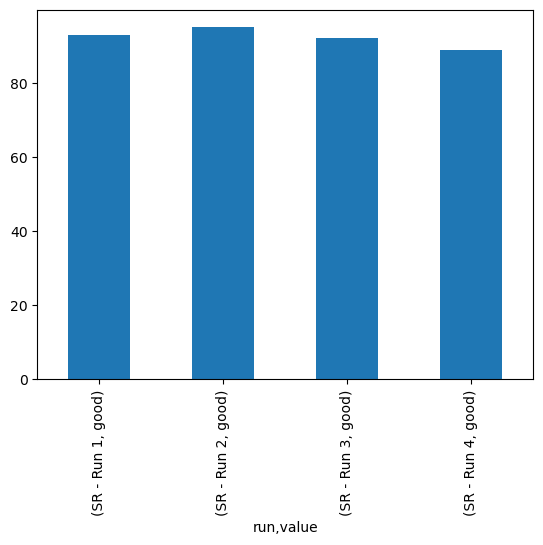

In [34]:
mriqc_melt_good_no_err = mriqc_melt_good[mriqc_melt_good['participant_id'].isin(task_audit_subjs_no_err)]
mriqc_melt_good_no_err.groupby('run')['value'].value_counts().plot.bar()


### Visualize Demographics

In [35]:
fmriprep_demo_qc_no = fmriprep_demo[fmriprep_demo['participant_id'].isin(mriqc_melt_good_no_err['participant_id'].unique())]


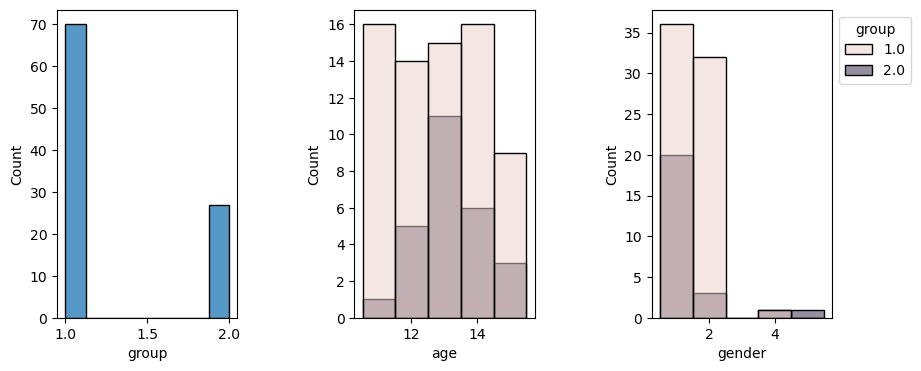

In [36]:
plt.figure(figsize=(10,4))

plt.subplot(1, 3, 1)
ax = sns.histplot(fmriprep_demo_qc_no, x='group')

plt.subplot(1, 3, 2)
sns.histplot(fmriprep_demo_qc_no, x='age', hue='group', legend=False)

plt.subplot(1, 3, 3)
ax = sns.histplot(fmriprep_demo_qc_no, x='gender', hue='group')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.subplots_adjust(wspace = 0.65)



### Export

In [37]:
mriqc_melt_good_no_err[['participant_id','run']].to_csv(proj_dir+'derivatives/participants-qc-no_task_errors.csv', 
                                                      index=False)

len(mriqc_melt_good_no_err['participant_id'].unique())


97